# **Awesome 1-step MNIST Generation**

# 1-step Mean Flows training on MNIST dataset.

Authors:

**Weijian Luo**, Peking University, https://pkulwj1994.github.io/;

**Yifei Wang**, Rice University, https://a-little-hoof.github.io/;

**Acknowledgements**: The **Awesome 1-step MNIST Generation** is built on the **Anotated Diffusion Blog**(https://huggingface.co/blog/annotated-diffusion) created by Niels Rogge and Kashif Rasul. We are glad to send our respects and appreciations to them for the awesome codebase on toy diffusion models.

In [ ]:
import tqdm
import datasets

In [ ]:
#!!pip install datasets

In [ ]:
#!pip install -q -U einops datasets matplotlib tqdm

In [ ]:
import os
import torch
from torch import nn
from torch import einsum
import torch.nn.functional as F
import numpy as np
from torchvision.datasets import MNIST
import torchvision.transforms as T
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

import math
from inspect import isfunction
from functools import partial

# %matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

In [ ]:
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['image.cmap'] = 'gray'
os.makedirs('save', exist_ok=True)

## Utility functions

In [ ]:
def grid(array, ncols=8):
    array = np.pad(array, [(0,0),(1,1),(1,1),(0,0)], 'constant')
    nindex, height, width, intensity = array.shape
    ncols = min(nindex, ncols)
    nrows = (nindex+ncols-1)//ncols
    r = nrows*ncols - nindex # remainder
    # want result.shape = (height*nrows, width*ncols, intensity)
    arr = np.concatenate([array]+[np.zeros([1,height,width,intensity])]*r)
    result = (arr.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return np.pad(result, [(1,1),(1,1),(0,0)], 'constant')



class NextDataLoader(torch.utils.data.DataLoader):
    def __next__(self):
        try:
            return next(self.iterator)
        except:
            self.iterator = self.__iter__()
            return next(self.iterator)



def to_tensor(obj, device='cuda'):
    if obj.shape[-1] != 3 and obj.shape[-1] != 1:
        obj = np.expand_dims(obj,-1)
    if obj.ndim < 4:
        obj = np.expand_dims(obj,0)
    t = torch.tensor(np.moveaxis(obj,-1,-3), dtype=torch.float, device=device)
    return t


def to_img(obj):
    array = np.moveaxis(obj.data.cpu().numpy(),-3,-1)
    return array

## Utility functions for neural networks

In [ ]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)

class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

## Mean Flows
Reference paper: [Mean Flows for One-step Generative Modeling](https://arxiv.org/abs/2505.13447).

The original method is implemented in jax, we provide a pytorch version.

### Mean Flows model
- We modify traditional UNet so that it can accept an additional timestep.

In [ ]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
            self.time_mlp_h = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time, h=None):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None
        # print(f"t shape: {t.shape if t is not None else 'None'}")

        if h is not None:
            # print(f"h shape: {h.shape}")
            t = t + self.time_mlp_h(h)
            # print(f"t shape after h addition: {t.shape}")

        h_list = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h_list.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h_list.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

### Mean Flows loss function
- Algorithm 1 in Mean Flows paper

In [ ]:
class MeanFlowLoss:
    def __init__(self, P_mean=-0.4, P_std=1.0,noise_dist='logit_normal', data_proportion=0.75, norm_p=1.0, norm_eps=1.0):
        self.P_mean = P_mean
        self.P_std = P_std
        self.data_proportion = data_proportion
        self.norm_p = norm_p
        self.norm_eps = norm_eps
        self.noise_dist = noise_dist

    def _logit_normal_dist(self, shape, device):
        rnd_normal = torch.randn(shape, device=device)
        return torch.sigmoid(rnd_normal * self.P_std + self.P_mean)

    def _uniform_dist(self, shape, device):
        return torch.rand(shape, device=device)

    def noise_distribution(self, shape, device):
        if self.noise_dist == 'logit_normal':
            return self._logit_normal_dist(shape, device)
        elif self.noise_dist == 'uniform':
            return self._uniform_dist(shape, device)
        else:
            raise ValueError(f"Unknown noise distribution: {self.noise_dist}")

    def __call__(self, net, images):
        x = images
        device = x.device
        batch_size = x.shape[0]
        shape = (batch_size, 1, 1, 1)

        t = self.noise_distribution(shape, device) # Sample t and r from noise distribution
        r = self.noise_distribution(shape, device)
        t, r = torch.max(t, r), torch.min(t, r)

        zero_mask = torch.arange(batch_size, device=device) < int(batch_size * self.data_proportion)
        zero_mask = zero_mask.view(shape)
        r = torch.where(zero_mask, t, r)  # Ensure t >= r and apply data proportion

        y = x

        n = torch.randn_like(y) # Create noise and corrupted image
        z_t = (1 - t) * y + t * n
        v = n - y  # True velocity

        v_g = v

        # Compute model output and time derivative
        def u_wrapper(z, t, r):
            return net(z, t.squeeze(), h=(t-r).squeeze())

        primals = (z_t, t, r)
        tangents = (v_g, torch.ones_like(t), torch.zeros_like(t))
        u, du_dt = torch.func.jvp(u_wrapper, primals, tangents)

        u_tgt = v_g - torch.clamp(t - r, min=0.0, max=1.0) * du_dt # Compute target velocity
        u_tgt = u_tgt.detach()

        unweighted_loss = (u - u_tgt).pow(2).sum(dim=[1, 2, 3]) # Adaptive loss weighting
        with torch.no_grad():
            adaptive_weight = 1 / (unweighted_loss + self.norm_eps).pow(self.norm_p)

        loss = unweighted_loss * adaptive_weight
        return loss.mean()


In [ ]:
print("cuda_available:", torch.cuda.is_available())


In [3]:
# xy = torch.rand(N, 2, device=device, requires_grad=True)                  # center (0~1)
# scale = torch.full((N, 2), 3.0, device=device, requires_grad=True)       # init node size
# feat = torch.rand(N, 1, device=device, requires_grad=True)        

# Gaussian Splatting

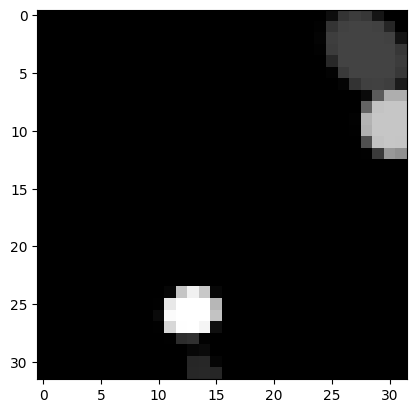

In [9]:
import matplotlib.pyplot as plt
import torch
from gmod.gsplat.project_gaussians_2d_scale_rot import project_gaussians_2d_scale_rot
from gmod.gsplat.rasterize_sum import rasterize_gaussians_sum
device = torch.device("cuda")

def render(features, size = (32, 32)):
    xy = features[:, 0:2]
    scale = features[:, 2:3]
    feat = features[:, 3:-1]
    rot = features[:, -1]
    B, N = features.shape[0:2]
    H, W = size
    tile_bounds = (W // 16, H // 16, 1)
    xy_pix, radii, conics, num_tiles_hit = project_gaussians_2d_scale_rot(xy, scale, rot, H, W, tile_bounds)
    out = rasterize_gaussians_sum(
        xy_pix, radii, conics, num_tiles_hit,
        feat, H, W,
        BLOCK_H=16, BLOCK_W=16,
        topk_norm=True
    )
    return out

# op = render(xy, scale, feat, (32, 32))
N = 10
op = render(torch.rand(N, 6).to(device))
plt.imshow(op[...,0].detach().cpu(), cmap = 'gray')

gsplat: CUDA extension already built. Loading from /home/abastol/.cache/torch_extensions/py311_cu124/gsplat_cuda.

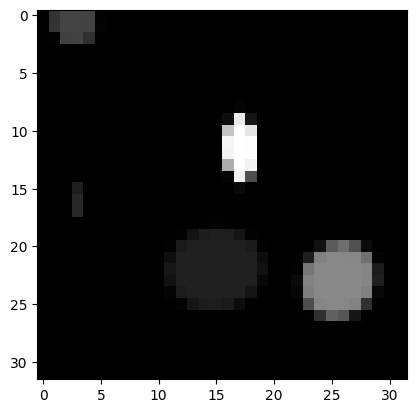

### Mean Flows training loop

In [ ]:
def train(mf, max_iter, batch_size, mf_opt_args,
          num_workers, val_interval, checkpoint=None):

    device = 'cuda'

    # create dataloader
    mean = 0.5
    std = 0.5
    dataset = MNIST('data', transform=T.Compose([T.ToTensor(), T.Pad(2), T.Normalize((mean,), (std,))]), download=True)
    dataloader = NextDataLoader(dataset, batch_size, num_workers=4, prefetch_factor=2, pin_memory=True)

    #eval_noise = torch.randn(64,1,32,32).to(device)
    # Gaussian Splatting mods
    


    # create optimizer
    mf_optimizer = torch.optim.Adam(mf.parameters(), **mf_opt_args)

    mf_loss = MeanFlowLoss()

    loss_history = []
    mf.train()
    for i in tqdm(range(max_iter)):

        x0 = next(dataloader)[0].to(device)
        print(x0.shape)
        print(eval_noise.shape)
        break

        loss = mf_loss(mf, x0)
        loss_history.append(loss.item())

        mf_optimizer.zero_grad()
        loss.backward()
        mf_optimizer.step()

        if i % val_interval == 0:

            mf.eval()
            with torch.no_grad():
                gen_x0 = generate(mf, eval_noise)
            mf.train()

            display.clear_output(wait=True)


            plt.figure(figsize=(5,5))
            gen_x0 = gen_x0.detach().permute(0,2,3,1).clamp(-1,1)*std + mean
            plt.title('diffusion sample', fontsize=17)
            plt.imshow(grid(gen_x0.cpu()).squeeze())
            plt.show()

            # 2. 实时绘制 loss 曲线
            if i != 0:
                plt.figure(figsize=(6, 4))
                plt.plot(loss_history, label='Training Loss')
                plt.title('Loss Curve')
                plt.xlabel('Iteration')
                plt.ylabel('Loss')
                plt.grid(True)
                plt.legend()
                plt.tight_layout()
                plt.show()

    torch.save({
                'mf': mf.state_dict(),
    }, 'save/mnist_mf.pt')

    print('training ends~ Have a good Day!')
    return None

### Mean Flows generation
- Algorithm 2 in Mean Flows paper

In [ ]:
def generate(mf, noise):
    B,C,H,W = noise.shape[0], noise.shape[1], noise.shape[2], noise.shape[3]

    z = noise
    t = torch.ones(B,1,1,1).to(noise.device)
    h = torch.ones_like(t)  # Initialize h as ones
    x0 = z-mf(noise, t.squeeze(), h.squeeze())

    return x0

### Start training!

In [ ]:
device = 'cuda'

train_params = {
    'max_iter': 20000,
    'batch_size' : 128,
    'mf_opt_args' : {'lr' : 0.001, 'betas' : (0.9, 0.99), 'eps' : 1e-08},
    'num_workers': 4,
    'val_interval': 100}

mf = Unet(
    dim=32,
    channels=1,
    dim_mults=(1, 2, 4, )
).to(device)

train(mf, **train_params)